In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# defaults
sns.set_style("white")

# Load Dataframes

In [16]:
path = os.path.join("../data/raw/funnel10/nuts_000cb98f665619fb6ab2aafc403ce455/chain_00/run_00/draws.csv")
nuts_df = pd.read_csv(path, sep="\t")
nuts_df.head()

,Unnamed: 0,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,...,v,theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],theta[7],theta[8],theta[9]
0,0,1.0,1.0,1.0,-8.28076,0.983358,0.083499,4.0,15.0,0.0,...,0.461389,2.832170,-0.340032,0.238798,-1.234550,2.229970,1.976060,0.513333,-0.773843,-0.434371
1,1,1.0,2.0,2.0,-4.88258,0.992028,0.083499,4.0,15.0,0.0,...,-0.301880,-1.685230,0.943087,-0.030949,0.647072,1.600220,-1.255590,0.298988,-0.006546,0.919991
2,2,1.0,3.0,3.0,-2.42492,0.999361,0.083499,4.0,15.0,0.0,...,-0.553555,1.489640,-0.265398,-0.875390,-0.282335,-0.576169,1.022380,-0.316585,-0.445215,-0.906434
3,3,1.0,4.0,4.0,-1.15381,0.996529,0.083499,3.0,7.0,0.0,...,-0.628943,-0.723548,-0.660786,-0.308825,-1.358200,-0.790985,-0.694308,-0.169865,0.322882,0.289360
4,4,1.0,5.0,5.0,-7.80142,0.910698,0.083499,3.0,15.0,0.0,...,0.855529,1.418380,-1.991150,1.501530,0.810409,1.712130,0.766532,1.459070,-1.557710,1.199770


In [17]:
path = os.path.join("../data/raw/funnel10")

# Explore Stan NUTS Parameters

<Axes: xlabel='n_leapfrog__', ylabel='Count'>

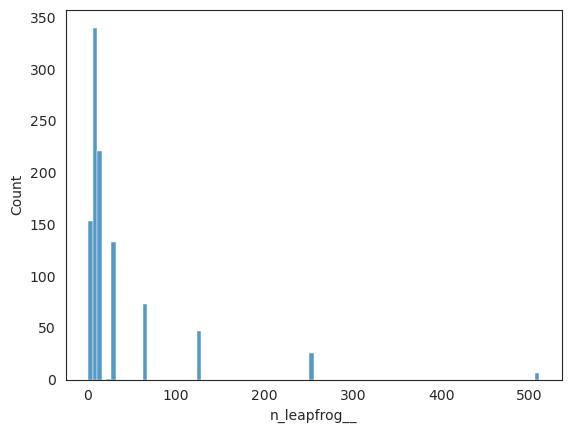

In [18]:
# plot histogram of nuts_df column "n_leapfrog__" 
sns.histplot(nuts_df["n_leapfrog__"], bins=100)

In [8]:
# compute 90% percentile of nuts_df column "n_leapfrog__"
leapfrog_90 = np.percentile(nuts_df["n_leapfrog__"], 90)
leapfrog_90

63.0

# Common-Sense Confirmation

<Axes: xlabel='v', ylabel='Density'>

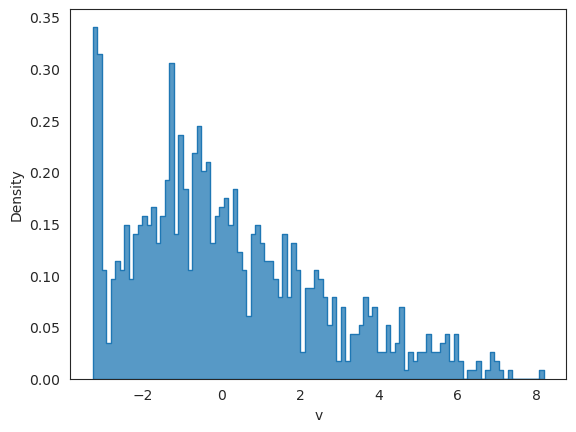

In [9]:
# with seaborn plot histogram of column "v" on x-axis and column "lp__" on y-axis, exponentiating the y-axis to remove the log scale
sns.histplot(x="v", data=nuts_df, log_scale=False, stat="density", element="step", bins=100)

# Quality of Approximation
#### Comparing NUTS vs DRHMC vs DRGHMC